# Boids algorithm

Presentation by Jakub Koralewski

**Plan**:

1. Boids terminology.
2. Original code (Boids description).
3. Refactor of the code.
4. Adding predators.
5. Population graph.

In [1]:
from faker import Faker
faker = Faker(['en_US', 'pl_PL', 'en_UK'])
faker.first_name()

'Nicole'

In [51]:
# For me to check if VPython isn't bugging out

from vpython import *
# VPython test
scene = canvas()
scene.range = 1.5
scene.title = "VPython test"
b = box()

<IPython.core.display.Javascript object>

# Boids algorithm

The name "boid" corresponds to a shortened version of "bird-oid object", which refers to a bird-like object.

A flock is a gathering of a group of same species animals in order to forage or travel with one another.

The Boids algorithm is defined by applying a set of rules to a set of boids (a flock). This mostly involves manipulating the position to achieve a simulation of a bird flock.

Details will become clear as we look into the code.

**Trivia**

Birds are a group of warm-blooded vertebrates. 

Birds are a group of feathered theropod dinosaurs and constitute the only living dinosaurs.

Birds are social, communicating with visual signals, calls, and songs, and participating in such behaviours as cooperative breeding and hunting, flocking, and mobbing of predators.

## The original code

Explores flocking behavior of flying "boids" aka "bird android".

Original code from: https://vpython.org/contents/contributed/boids.py

Written by: 
  Eric Nilsen
  September 2003
  ericjnilsen@earthlink.net

Adapted from:
  
    http://www.vergenet.net/~conrad/boids/pseudocode.html
  
  Thanks to Conrad Parker conrad@vergenet.net for the boids pseudocode.
  Which was first published in [January 2001](https://web.archive.org/web/20020127144959/http://www.vergenet.net/~conrad/boids/pseudocode.html) making this code 20 years old.

Small changes and fixes by
    Jakub Koralewski to adapt to VPython 7 running inside a Jupyter Notebook

In [41]:
from random import randrange
class Boids:
    RADIUS = 1                 #radius of a boid.  I wimped and used spheres.
    FACTOR = .95               #the amount of movement to the perceived flock center
    DT = 0.02                  #delay time between snapshots
    def init_scene(self):
        global scene
        scene.title = "Boids v1"
    
    def __init__(self, numboids = 10, sidesize = 100.0, log=False):     #class constructor with default parameters filled
        self.running = True
        self.prev_length = 100
        self.prev_speed = 100
        self.init_scene()
        #scene.bind('mouseup', self.toggle)
        self.log = log

        self.SIDE = sidesize            #unit for a side of the flight space

        #the next six lines define the boundaries of the torus
        """
        torus:  donut shaped space, i.e. infinite # jakkor: dunno why its called a torus, its clearly a cube
        effect: boids flying out of bounds appear at the opposite side
        note:   cartesian matrices don't handle toruses very well, but I couldn't
                figure out a better way to keep the flock in view.
        """
        self.MINX = self.SIDE * -1.0    #left
        self.MINY = self.SIDE * -1.0    #bottom
        self.MINZ = self.SIDE * -1.0    #back
        self.MAXX = self.SIDE           #right
        self.MAXY = self.SIDE           #top
        self.MAXZ = self.SIDE           #front
        
        self.NEARBY = self.RADIUS * 5   #the 'halo' of space around each boid
        
        self.NUMBOIDS = numboids        #the number of boids in the flock

        self.boidflock = []             #empty list of boids

        #okay, now that all the constants have initialized, let's fly!
    
    def toggle(self):
        self.running = not self.running
        if self.running:
            print("restarting")
            for b in self.boidflock:
                b.visible = False
                del b
            del self.boidflock
            self.boidflock = []
            rate(100000)
            global scene
            scene.waitfor('redraw')
            self.boids(length=self.prev_length, speed=self.prev_speed)

    def boids(self, length=100, speed=100):
        self.prev_length=length
        self.prev_speed=speed
        self.initializePositions()      #create a space with boids

        x = length
        while x > 0 and self.running:                   #loop forever
            rate(speed)                   #controls the animation speed, bigger = faster
            self.moveAllBoidsToNewPositions()   #um ... what it says
            x -= 1
            
    def initializePositions(self):
        #wire frame of space
        backBottom = curve(pos=[(self.MINX, self.MINY, self.MINZ), (self.MAXX, self.MINY, self.MINZ)], color=color.white)
        backTop = curve(pos=[(self.MINX, self.MAXY, self.MINZ), (self.MAXX, self.MAXY, self.MINZ)], color=color.white)
        frontBottom = curve(pos=[(self.MINX, self.MINY, self.MAXZ), (self.MAXX, self.MINY, self.MAXZ)], color=color.white)
        frontTop = curve(pos=[(self.MINX, self.MAXY, self.MAXZ), (self.MAXX, self.MAXY, self.MAXZ)], color=color.white)
        leftBottom = curve(pos=[(self.MINX, self.MINY, self.MINZ), (self.MINX, self.MINY, self.MAXZ)], color=color.white)
        leftTop = curve(pos=[(self.MINX, self.MAXY, self.MINZ), (self.MINX, self.MAXY, self.MAXZ)], color=color.white)
        rightBottom = curve(pos=[(self.MAXX, self.MINY, self.MINZ), (self.MAXX, self.MINY, self.MAXZ)], color=color.white)
        rightTop = curve(pos=[(self.MAXX, self.MAXY, self.MINZ), (self.MAXX, self.MAXY, self.MAXZ)], color=color.white)
        backLeft = curve(pos=[(self.MINX, self.MINY, self.MINZ), (self.MINX, self.MAXY, self.MINZ)], color=color.white)
        backRight = curve(pos=[(self.MAXX, self.MINY, self.MINZ), (self.MAXX, self.MAXY, self.MINZ)], color=color.white)
        frontLeft = curve(pos=[(self.MINX, self.MINY, self.MAXZ), (self.MINX, self.MAXY, self.MAXZ)], color=color.white)
        frontRight = curve(pos=[(self.MAXX, self.MINY, self.MAXZ), (self.MAXX, self.MAXY, self.MAXZ)], color=color.white)

        #splatter a flock in the space randomly
        c = 0                                   #initialize the color switch
        for b in range(self.NUMBOIDS):          #for each boid, ...
            x = randrange(self.MINX, self.MAXX) #random left-right
            y = randrange(self.MINY, self.MAXY) #random up-down
            z = randrange(self.MINZ, self.MAXZ) #random front-back

            if c > 2:                           #reset the color switch when it grows too big
                c = 0
            if c == 0:
                COLOR = color.yellow            #a third of the boids shall have yellow
            if c == 1:
                COLOR = color.green               #and yea a third of the boids shall have green
            if c == 2:
                COLOR = color.blue              #and verily a third of the boids shall have blue

            #splat a boid, add to flock list
            #jakkor: FIX 1. Turn pos into a vector from a tuple
            b = sphere(pos=vector(x,y,z), radius=self.RADIUS, color=COLOR)
            b.name = faker.first_name()
            b.eaten = False
            b.followed = False
            self.boidflock.append(b)

            
            c += 1                           #increment the color switch

##        self.greenie = sphere(radius=self.RADIUS, color=color.green)    #pseudo-boid for testing
        

    def moveAllBoidsToNewPositions(self):
        for b in range(self.NUMBOIDS):
            
            #Clamping boids's positions hitting the torus 'boundaries'
            #jakkor: FIX 2. `pos.x` instead of `.x`
            if self.boidflock[b].pos.x < self.MINX:
                self.boidflock[b].pos.x = self.MAXX
                
            if self.boidflock[b].pos.x > self.MAXX:
                self.boidflock[b].pos.x = self.MINX
                
            if self.boidflock[b].pos.y < self.MINY:
                self.boidflock[b].pos.y = self.MAXY
                
            if self.boidflock[b].pos.y > self.MAXY:
                self.boidflock[b].pos.y = self.MINY
                
            if self.boidflock[b].pos.z < self.MINZ:
                self.boidflock[b].pos.z = self.MAXZ
                
            if self.boidflock[b].pos.z > self.MAXZ:
                self.boidflock[b].pos.z = self.MINZ
            #jakkor: FIX 3. Got rid of useless 0 vectors overriden instantly
 
            v1 = self.rule1(b)              #get the vector for rule 1
            v2 = self.rule2(b)              #get the vector for rule 2
            v3 = self.rule3(b)              #get the vector for rule 3

            boidvelocity = v1 + v2 + v3         #initialize the boid velocity; accumulate the rules vector results
            self.boidflock[b].pos += boidvelocity*self.DT #move the boid

                

    def rule1(self, aboid):    #Rule 1:  boids fly to perceived flock center
        pfc = vector(0.0,0.0,0.0)                   #pfc: perceived flock center
        for b in range(self.NUMBOIDS):              #for all the boids
            if b != aboid:                          #except the boid at hand
                 pfc = pfc + self.boidflock[b].pos  #calculate the total pfc
        # once we start killing the birds we cant be using a constant
        pfc = pfc/(self.NUMBOIDS - 1.0)             #average the pfc
##        self.greenie.pos = pfc                      #put greenie at the pfc, see what's going on

        #nudge the boid in the correct direction toward the pfc 
        if pfc.x > self.boidflock[aboid].pos.x:
            pfc.x = (pfc.x - self.boidflock[aboid].pos.x)*self.FACTOR
        if pfc.x < self.boidflock[aboid].pos.x:
            pfc.x = (self.boidflock[aboid].pos.x - pfc.x)*-self.FACTOR
        if pfc.y > self.boidflock[aboid].pos.y:
            pfc.y = (pfc.y - self.boidflock[aboid].pos.y)*self.FACTOR
        if pfc.y < self.boidflock[aboid].pos.y:
            pfc.y = (self.boidflock[aboid].pos.y - pfc.y)*-self.FACTOR
        if pfc.z > self.boidflock[aboid].pos.z:
            pfc.z = (pfc.z - self.boidflock[aboid].pos.z)*self.FACTOR
        if pfc.z < self.boidflock[aboid].pos.z:
            pfc.z = (self.boidflock[aboid].pos.z - pfc.z)*-self.FACTOR

        return pfc 

    def rule2(self, aboid):    #Rule 2: boids avoid other boids
        v = vector(0.0,0.0,0.0) #initialize the avoidance vector

        for b in range(self.NUMBOIDS):
            if b != aboid:
                if abs(self.boidflock[b].pos.x - self.boidflock[aboid].pos.x) < self.NEARBY:
                    if self.boidflock[b].pos.x > self.boidflock[aboid].pos.x:
                        v.x = self.NEARBY * 12.0    #works better when I multiply by 12, don't know why
                    if self.boidflock[b].pos.x < self.boidflock[aboid].pos.x:
                        v.x = -self.NEARBY * 12.0
                if abs(self.boidflock[b].pos.y - self.boidflock[aboid].pos.y) < self.NEARBY:
                    if self.boidflock[b].pos.y > self.boidflock[aboid].pos.y:
                        v.y = self.NEARBY * 12.0
                    if self.boidflock[b].pos.y < self.boidflock[aboid].pos.y:
                        v.y = -self.NEARBY * 12.0
                if abs(self.boidflock[b].pos.z - self.boidflock[aboid].pos.z) < self.NEARBY:
                    if self.boidflock[b].pos.z > self.boidflock[aboid].pos.z:
                        v.z = self.NEARBY * 12.0
                    if self.boidflock[b].pos.z < self.boidflock[aboid].pos.z:
                        v.z = -self.NEARBY * 12.0

        return v
        
    def rule3(self, aboid):    #Rule 3: boids try to match speed of flock
        pfv = vector(0.0,0.0,0.0)   #pfv: perceived flock velocity
            
        for b in range(self.NUMBOIDS):
            if b != aboid:
                 pfv = pfv + self.boidflock[b].pos

        pfv = pfv/(self.NUMBOIDS - 1.0)
        pfv = pfv/(aboid + 1)    #some of the boids are more sluggish than others
        
        return pfv

## Example

In [53]:
scene = canvas()
scene.range = 100
# VPython seems to be bugging making the animation really short, hope it works during the presentation 🤞 
Boids(numboids=10).boids(length=200, speed=100)

<IPython.core.display.Javascript object>

# Refactor

The following slides will all be part of a rewrite of the original code shown above.

## 1. Rules into classes

We want to be able to dynamically choose which rules we would like to run like so:

```py
Boids2([Rule1, Rule2, Rule3])
```

This will help when we add specific predator behaviors which we can then tweak. Will also help explain how Boids algorithm works.

In [5]:
# A Python "abstract" class
class Rule:
    # Right now only this method is useful
    def rule(self, boids: Boids, cur: int) -> vector:
        # This runs for every boid (cur is the boids index)
        # you return a vector that will move the given boid
        raise Exception("put rule code that moves cur bird") # <- needs to be overriden
    
    # ----
    # The ones below are useful for state-ful rules: predator rules
    def __init__(self, boids: Boids):
        # This code will be ran when the Boids class is initialized
        # so you can initialize stuff for your rule here
        pass 
    
    def on_frame_finish(self, boids: Boids):
        # this method will be called after applying each rule to each boid in a given frame
        # put some custom stuff here, e.g. predators are in a separate collection so
        # you can manipulate it here
        pass

### 1. Boids fly to perceived flock center

In [42]:
class FlyToCenter(Rule): #Rule 1:  boids fly to perceived flock center
    def rule(self, boids: Boids, cur: int) -> vector:   
        num = len(boids.boidflock)
        pfc = vector(0.0,0.0,0.0)                   #pfc: perceived flock center
        for b in range(num):              #for all the boids
            if b != cur:                          #except the boid at hand
                 pfc = pfc + boids.boidflock[b].pos  #calculate the total pfc

        # From perspective of one of the birds the flock does not include yourself (hence -1)
        pfc = pfc/(num - 1.0)             #average the pfc
        pos = boids.boidflock[cur].pos              #current boid's pos

        #nudge the boid in the correct direction toward the pfc 
        if pfc.x > pos.x: # if flock to the right then go right
            pfc.x = (pfc.x - pos.x)*boids.FACTOR # by some factor
        if pfc.x < pos.x:
            pfc.x = (pos.x - pfc.x)*-boids.FACTOR # removed NEGFACTOR in favor of simply -boids.FACTOR
        if pfc.y > pos.y:
            pfc.y = (pfc.y - pos.y)*boids.FACTOR
        if pfc.y < pos.y:
            pfc.y = (pos.y - pfc.y)*-boids.FACTOR
        if pfc.z > pos.z:
            pfc.z = (pfc.z - pos.z)*boids.FACTOR
        if pfc.z < pos.z:
            pfc.z = (pos.z - pfc.z)*-boids.FACTOR
        
        return pfc

### 2. Boids avoid other boids

In [7]:
class AvoidOtherBoids(Rule): #Rule 2: boids avoid other boids
    # for each boid
    def rule(self, boids: Boids, cur: int) -> vector:   
        v = vector(0.0,0.0,0.0) #initialize the avoidance vector
        cur_pos = boids.boidflock[cur].pos

        # and each another boid [O(n^2)]
        for b in range(len(boids.boidflock)):
            if b != cur:
                b_pos = boids.boidflock[b].pos
                if abs(b_pos.x - cur_pos.x) < boids.NEARBY:
                    if b_pos.x > cur_pos.x:
                        v.x = boids.NEARBY * 12.0    #works better when I multiply by 12, don't know why
                    if b_pos.x < cur_pos.x:
                        v.x = -boids.NEARBY * 12.0
                if abs(b_pos.y - cur_pos.y) < boids.NEARBY:
                    if b_pos.y > cur_pos.y:
                        v.y = boids.NEARBY * 12.0
                    if b_pos.y < cur_pos.y:
                        v.y = -boids.NEARBY * 12.0
                if abs(b_pos.z - cur_pos.z) < boids.NEARBY:
                    if b_pos.z > cur_pos.z:
                        v.z = boids.NEARBY * 12.0
                    if b_pos.z < cur_pos.z:
                        v.z = -boids.NEARBY * 12.0
        return v

### 3. Boids try to match speed of flock

In [8]:
class MatchFlockSpeed(Rule): #Rule 3: boids try to match speed of flock
    def rule(self, boids: Boids, cur: int) -> vector:   
        pfv = vector(0.0,0.0,0.0)   #pfv: perceived flock velocity
        num = len(boids.boidflock)
        # again for each other boid
        for b in range(num):
            if b != cur:
                 pfv += boids.boidflock[b].pos

        pfv = pfv/(num - 1.0)
        pfv = pfv/(cur + 1)    #some of the boids are more sluggish than others
        
        return pfv

## 2. Boids class refactored to use those classes

In [9]:
class Boids2(Boids): # inherit from original Boids and overwrite __int__ and moveAllBoidsToNewPositions
    def __init__(self, rules: list[Rule], numboids = 10, sidesize = 100.0, log=True):     #class constructor with default parameters filled
        super().__init__(numboids, sidesize, log)
        self.rules = [rule(self) for rule in rules]
        self.should_stop = False
        global scene
        scene.title = "Boids v2"
    
    def boids(self, length=300, speed=100):
        self.initializePositions()      #create a space with boids
        x = length
        global scene
        scene.bind('mousedown', self.stop)
        while x > 0 and not self.should_stop:                   
            rate(speed)                   #controls the animation speed, bigger = faster
            try:
                self.moveAllBoidsToNewPositions()   #um ... what it says
            except Boids2.NotEnoughBirdsLeft as e:
                print(e)
                if self.log:
                    print("Lone survivor: ", self.boidflock[0].name)
                break
            x -= 1
        
    
    def stop(self):
        self.should_stop = not self.should_stop
    
    class NotEnoughBirdsLeft(Exception):
        def __init__(self):
            super().__init__("Not enough birds (1 is not a flock)")

    def moveAllBoidsToNewPositions(self):
        for i, b in enumerate(self.boidflock):
            if b.eaten:
                continue
            if b.pos.x < self.MINX:
                b.pos.x = self.MAXX               
            elif b.pos.x > self.MAXX:
                b.pos.x = self.MINX
                
            if b.pos.y < self.MINY:
                b.pos.y = self.MAXY    
            elif b.pos.y > self.MAXY:
                b.pos.y = self.MINY
                
            if b.pos.z < self.MINZ:
                b.pos.z = self.MAXZ  
            elif b.pos.z > self.MAXZ:
                b.pos.z = self.MINZ

            boidvelocity = vector(0, 0, 0)
            for rule in self.rules:
                rule_out = rule.rule(self, i)
                boidvelocity += rule_out  #jakkor: output of rules is accumulated
            #jakkor: and then added to the position of the particular boid
            b.pos += boidvelocity*self.DT #move the boid
        for rule in self.rules:
            rule.on_frame_finish(self)
        if len(self.boidflock) <= 1: # OG algorithm does not work with 1 bird as it divides by (num-1)
            raise Boids2.NotEnoughBirdsLeft


Let's test it!

It *should* work same as before.

In [54]:
scene = canvas()
scene.range = 100
Boids2([FlyToCenter, AvoidOtherBoids, MatchFlockSpeed]).boids()

<IPython.core.display.Javascript object>

## Adding predators (and their rules)

![](https://crops.giga.de/ea/a9/06/10fcbb64359cd4315b98f741f6_YyAxODI1eDEwMjYrOTArNwJyZSA1MDAgMjgwA2U5MWM2NWQxOTdm.jpg)

## 1. Predators exist

Defines number of predators and their existence. This is the rule of life.

In [11]:
class PredatorsExist(Rule): # Predators exist in real life :O
    def rule(self, boids: Boids, cur: int) -> vector:
        return vector(0,0,0) # dummy rule, we don't affect birds in any way!
    
    def __init__(self, num: int = 1):
        self.num_predators = num # we use __init__ for config
    
    # We use __call__ to mimick __init__ when not using __init__ for config
    def __call__(self, boids: Boids):
        # Initialize predator geometry
        boids.predatorflock = []
        for _ in range(self.num_predators):
            # Pick a random place
            x = randrange(boids.MINX, boids.MAXX) #random left-right
            y = randrange(boids.MINY, boids.MAXY) #random up-down
            z = randrange(boids.MINZ, boids.MAXZ) #random front-back
            
            # Same as for boids, except larger and red
            p = sphere(pos=vector(x,y,z), radius=boids.RADIUS*5, color=color.red)
            p.eating = False
            p.name = faker.name()
            p.followed_bird = None
            boids.predatorflock.append(p) 
        
        return self

## 2. Predators chase Perceived Flock Center

Can be replaced by 3rd rule. Predators go into the "general" direction of the flock. 

In [12]:
class PredatorsChasePFC(Rule): # Predators chase Perceived Flock Center
    FACTOR = 2 # speed of predators
    def rule(self, boids, cur):
        return vector(0,0,0) # again not affecting birds

    def on_frame_finish(self, boids: Boids):
        # After all birds have been moved
        
        # Predator chases birds
        for p in boids.predatorflock:
            if p.eating:
                continue
            pos = p.pos
            num = len(boids.boidflock)
            pfc = vector(0.0,0.0,0.0)                   #pfc: perceived flock center
            # jakkor idea:
            # Predators chase a random subset of boids to not be carbon-copies of each other
            rand_seen = floor(random() * len(boids.boidflock))
            rand2 = random() < 0.5
            for b in (boids.boidflock[rand_seen:] if rand2 else boids.boidflock[:rand_seen]):
                pfc += b.pos  #calculate the total pfc

            pfc = pfc/num             #average the pfc

            #nudge the boid in the correct direction toward the pfc 
            p.pos += (pfc-p.pos)*boids.FACTOR*self.FACTOR*boids.DT

## 3. Predators chase closest bird

![](https://timeoutcdn-new-york.s3.amazonaws.com/GIFs/marvel/8.gif)

Can be replaced by 2nd rule. Predators choose the closest bird and stick to it to a certain defined period called "memory".

In [13]:
from heapq import heappush,heappop
from dataclasses import dataclass

@dataclass
class FollowedBird:
    frame: int # since frame
    bird: sphere

class PredatorsChaseClosestBird(Rule): # Predators chase closest bird
    FACTOR = 2 # speed of predators
    def rule(self, boids, cur):
        return vector(0,0,0)
    # A memory (in frames) is passed in
    def __init__(self, memory=0):
        self.frame = 0
        self.memory = memory # the length of frames for which the predator follows a single bird
    
    def __call__(self, boids: Boids):
        return self

    def on_frame_finish(self, boids: Boids):
        # We count frames here
        self.frame += 1
        # After all birds have been moved
        
        # Predator chases birds
        for p in boids.predatorflock:
            if p.eating: # can't eat two at a time
                continue
            pos = p.pos
            num = len(boids.boidflock)
            closest_bird = None
            # if not following any bird (beginning) or forgot who we're chasing
            if not p.followed_bird or (p.followed_bird.frame + self.memory) < self.frame:
                
                # Pick new bird to follow
                p.followed_bird = None
                
                # We use a heap to get the minimal distance without sorting
                distances = []
                for b in boids.boidflock:              #for all the boids
                    heappush(distances, ((b.pos - p.pos).mag, b))
                
                dist, closest_bird = heappop(distances)
                while closest_bird.followed and len(distances) > 0: 
                    #print(f"{closest_bird.name} was being followed by {closest_bird.followed.name} already")
                    dist, closest_bird = heappop(distances)

                closest_bird.followed = p
                if p.followed_bird:
                    p.followed_bird.followed = False
                p.followed_bird = FollowedBird(frame=self.frame, bird=closest_bird)
                #print(f"{p.name} following new bird {closest_bird.name}")
            else:
                # Already following a bird
                closest_bird = p.followed_bird.bird
            # Move into direction of this bird
            p.pos -= (p.pos-closest_bird.pos)*boids.DT*self.FACTOR

## 4. Birds escape predators

Birds try to avoid the predators.

In [14]:
#FIXME (didn't have time to fix): in slow-motion doesnt look like they are really escaping?
class BirdsEscapePredators(Rule): # Birds try to escape predators
    def rule(self, boids: Boids, cur: int) -> vector:
        # For each bird
        b = boids.boidflock[cur]
        v = vector(0,0,0)
        # For each predator
        for p in boids.predatorflock:
            cur_pos = p.pos
            b_pos = b.pos
            if abs(b_pos.x - cur_pos.x) < boids.NEARBY:
                if b_pos.x > cur_pos.x:
                    v.x = boids.NEARBY * 12.0    #works better when I multiply by 12, don't know why
                elif b_pos.x < cur_pos.x:
                    v.x = -boids.NEARBY * 12.0
            if abs(b_pos.y - cur_pos.y) < boids.NEARBY:
                if b_pos.y > cur_pos.y:
                    v.y = boids.NEARBY * 12.0
                elif b_pos.y < cur_pos.y:
                    v.y = -boids.NEARBY * 12.0
            if abs(b_pos.z - cur_pos.z) < boids.NEARBY:
                if b_pos.z > cur_pos.z:
                    v.z = boids.NEARBY * 12.0
                elif b_pos.z < cur_pos.z:
                    v.z = -boids.NEARBY * 12.0
        return v

## 5. Predators eat birds

Once a predator gets sufficiently close to a bird, it stops in mid-air for a certain period of time to eat it.

In [15]:
from dataclasses import dataclass
@dataclass
class Meal:
    predator_index: int # predator
    predator: sphere
    b: sphere # bird
    frame: int # frame when started eating 

class PredatorsEatBirds(Rule):
    AFTER_FRAMES = 5 # head start; Time for birds to run away in case generated close to each other
    
    def __init__(self, vicinity_to_eat = 20, time_to_eat = 50):
        self.vicinity_to_eat = vicinity_to_eat
        self.pizza_time_length = time_to_eat # time for predator to finish his meal
        self.frame = 0
        self.meals: list[Meal] = []
        
    def __call__(self, boids: Boids):
        return self
    
    def rule(self, boids, cur):   
        return vector(0,0,0)
    
    def remove_meal(self, m: Meal, boids: Boids) -> bool:
        m.predator.eating = False
        m.predator.radius += 0.5
        m.b.visible = False
        del m
        return False

    def on_frame_finish(self, boids: Boids): 
        self.frame += 1
        if self.frame <= self.AFTER_FRAMES:
            return
        # Check if finished eating
        
        # stop eating if finished
        filtered_meals = []
        boids_to_remove = []
        for m in self.meals:
            if self.frame - m.frame > self.pizza_time_length:
                self.remove_meal(m, boids)
                boids_to_remove.append(m.b)
            else:
                filtered_meals.append(m)
        boids.boidflock = list(filter(lambda b: b not in boids_to_remove, boids.boidflock))
        self.meals = filtered_meals
        def in_vicinity(p: sphere):
            cur_pos = p.pos
            return ((b_pos - cur_pos).mag < self.vicinity_to_eat)
        
        for b in boids.boidflock:
            if b.eaten:
                continue
            b_pos = b.pos
            # info if b is dead (including which predator killed it) or None
            kill_iter = filter(lambda x: x[0], map(lambda x: (in_vicinity(x[1]), x[0], x[1]), enumerate(boids.predatorflock)))
            kill = next(kill_iter, None)
            if kill:
                predator_index, predator = kill[1:]
                if predator.eating:
                    continue # predator can only eat one bird at a time
                if boids.log:
                    print(f"bird {b.name} being eaten by {predator.name}")
                # Eating predators and eaten birds stop moving
                predator.eating = True
                b.eaten = True
                self.meals.append(Meal(predator_index=predator_index, predator=predator, b=b, frame=self.frame))

## 6. Predators avoid other predators.

Otherwise they overlap. This doesn't fix the issue where if the predators are following the 2nd rule (Chase Perceived Flock Center) they fly the exact same path, but it fixes the issue where they form a single overlapping predator.

In [16]:
class PredatorsAvoidOtherPredators(Rule): #Rule: predators dont overlap
    def rule(self, boids: Boids, cur: int) -> vector:   
        return vector(0,0,0)


    def on_frame_finish(self, boids: Boids):
        # After all birds have been moved
    
        for i, p1 in enumerate(boids.predatorflock):
            v = vector(0.0,0.0,0.0) #initialize the avoidance vector
            cur_pos = p1.pos
            p1_rad = p1.radius**3
            for p2 in boids.predatorflock[i+1:]:
                radii_sum = p1.radius + p2.radius
                b_pos = p2.pos
                # Get vector from one predator to another
                displacement = p2.pos - p1.pos
                # Check if distance is smaller than sum of their radii
                dist = displacement.mag - radii_sum
                scene.caption = dist
                if dist < 1:
                    v -= displacement.hat*(-dist)*2
            
            p1.pos += v

## Example

In [65]:
scene = canvas()
scene.range = 100
Boids2([
    FlyToCenter, AvoidOtherBoids, MatchFlockSpeed, # <- regular rules exist for birds to move
    PredatorsExist(num=2), # <- specify number of predators
    #PredatorsChasePFC, 
    PredatorsChaseClosestBird(memory=100), # <- looks a bit more natural than PredatorsChasePFC
    BirdsEscapePredators, # <- interesting without this
    PredatorsEatBirds(vicinity_to_eat=20), # <- boring without this
    PredatorsAvoidOtherPredators # <- predators overlap without this (in PFC mode)
], numboids=20).boids(length=2000, speed=100)

<IPython.core.display.Javascript object>

bird Denise being eaten by Alan Webster
bird Gillian being eaten by Brandon Young-Smith
bird Allan being eaten by Brandon Young-Smith
bird Latasha being eaten by Brandon Young-Smith
bird Klara being eaten by Alan Webster
bird Charles being eaten by Brandon Young-Smith
bird Gabriel being eaten by Alan Webster
bird Maria being eaten by Brandon Young-Smith
bird Tobiasz being eaten by Alan Webster
bird Cezary being eaten by Brandon Young-Smith
bird William being eaten by Alan Webster
bird Anthony being eaten by Brandon Young-Smith
bird Tomasz being eaten by Brandon Young-Smith
bird Alexis being eaten by Alan Webster
bird Hazel being eaten by Alan Webster
bird Aaron being eaten by Brandon Young-Smith
bird Stuart being eaten by Alan Webster
bird Roger being eaten by Brandon Young-Smith
bird Hugh being eaten by Alan Webster
Not enough birds (1 is not a flock)
Lone survivor:  Tonya


## Bug (I think it is fixed now)

Once the birds get dispersed throughout the cube, and the predator stays in the middle, since the predator follows the "Perceived Flock Center" and also since the birds try to avoid the center where the predator is, we enter a buggy equilibrium state where the predator can't pick a direction.

## Refactor to get population information through time

To be able to graph the changes in population over time we need to make the following possible:

1. After the `.boids()` function is called it should return the data of both the birds and predators.


2. The `.boids()` function should accept an optional parameter that would make rendering faster.

In [37]:
@dataclass
class BoidsData:
    population: list[tuple[int, int]]

class Boids3(Boids2): # inherit from original Boids and overwrite __int__ and moveAllBoidsToNewPositions
    def __init__(self, rules: list[Rule], numboids = 10, sidesize = 100.0, log=False):     #class constructor with default parameters filled
        super().__init__(rules, numboids, sidesize, log)
        global scene
        scene.title = "Boids v3"
        self._moveAllBoidsToNewPositions = self.moveAllBoidsToNewPositions
        self.data = BoidsData([])
    
    def boids(self, length=300, speed=100):
        self.initializePositions()      #create a space with boids
        x = 0
        
        while x < length and not self.should_stop: 
            rate(speed)
            try:
                self.moveAllBoidsToNewPositions()
            except Boids2.NotEnoughBirdsLeft:
                break
            self.update_data()
            x += 1
        return self.data # boids() now returns data

    def update_data(self):
        self.data.population.append((len(self.boidflock), len(self.predatorflock)))

In [19]:
from matplotlib import pyplot as plt

## Plotting population

<IPython.core.display.Javascript object>

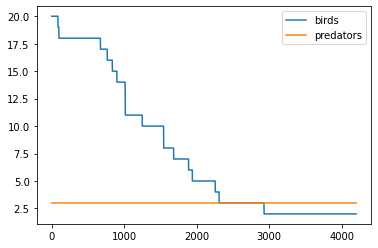

In [60]:
scene = canvas()
scene.range = 100
data = Boids3([
    FlyToCenter, AvoidOtherBoids, MatchFlockSpeed, 
    PredatorsExist(num=3), 
    PredatorsChasePFC,
    #PredatorsChaseClosestBird(memory=5),
    BirdsEscapePredators,
    PredatorsEatBirds(vicinity_to_eat=10),
    PredatorsAvoidOtherPredators
], numboids=20, log=False).boids(length=8000, speed=10000); # speed parameter *speeds* things up

ax = plt.gca()
ax.plot(data.population);
ax.legend(["birds", "predators"]);

## Ideas for more rules

1. Predators starve when not eating any birds.
2. Predators reproduce when ate enough birds. Random mutations could cause decrease of speed but increase of minimal vicinity to eat (kill range) etc. to make for more diverse and interesting ecosystem.
3. Birds reproduce if not eaten for a while.

New generations inherit the speed factors of their parent(s) with slight mutations selecting for increasingly faster movement. 

4. Predators have territories (part of the cube), and fight other predators for them.
5. Predators are smart and work together: each predator gets assigned birds, chosen by how close they are to the given predator. No bird is assigned to two predators, unless there are so many predators that some have nothing else to do. This could fix them sticking together similar to closest bird strategy.

But for such more complex behavior maybe it would make more sense to use Godot (which can be scripted with Python), Unity etc.

## Sources

- https://vpython.org/contents/contributed/boids.py
- http://www.vergenet.net/~conrad/boids/pseudocode.html
- https://en.wikipedia.org/wiki/Boids
- https://en.wikipedia.org/wiki/Bird#Flocking_and_other_associations
- https://en.wikipedia.org/wiki/Flock_(birds)